In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA, TruncatedSVD, FastICA

In [52]:
cowpea = pd.read_excel('../data/prepared.xlsx', sheet_name='Cowpea')    ; cowpea['crop']   = 'cowpea'
maize = pd.read_excel('../data/prepared.xlsx', sheet_name='Maize')      ; maize['crop']    = 'maize'
rice = pd.read_excel('../data/prepared.xlsx', sheet_name='Rice')        ; rice['crop']     = 'rice'
chickpea = pd.read_excel('../data/prepared.xlsx', sheet_name='Chickpea'); chickpea['crop'] = 'chickpea'
mustard = pd.read_excel('../data/prepared.xlsx', sheet_name='Mustard')  ; mustard['crop']  = 'mustard'

In [53]:
data = pd.concat([cowpea, rice, maize, chickpea, mustard], axis=0).reset_index(drop=True)

In [54]:
clf = LocalOutlierFactor(n_neighbors=20, p=2)

new_data = []
org_cols = data.columns
for i, outlier_label in enumerate(clf.fit_predict(data[['GSR', 'CT']])):
    if outlier_label==1:
        new_data.append(data.iloc[i,:])
data = pd.DataFrame(new_data, columns=org_cols)

In [55]:
data.loc[:, 'Time'] = data.loc[:, 'Time'].apply(lambda x: x.hour)
data.loc[:, 'timesin'] = np.sin(data.loc[:, 'Time'] * (2 * np.pi) / 12)
data.loc[:, 'timecos'] = np.cos(data.loc[:, 'Time'] * (2 * np.pi) / 12)

In [56]:
df = pd.get_dummies(data[['crop']])
data = pd.concat([df, data], axis=1)

In [71]:
feature_cols = [c for c in data.columns if c not in ['ST_5cm','ST_10cm','ST_15cm','Date','Time','crop','Rn']]
X = data[feature_cols]
y = data['Rn']

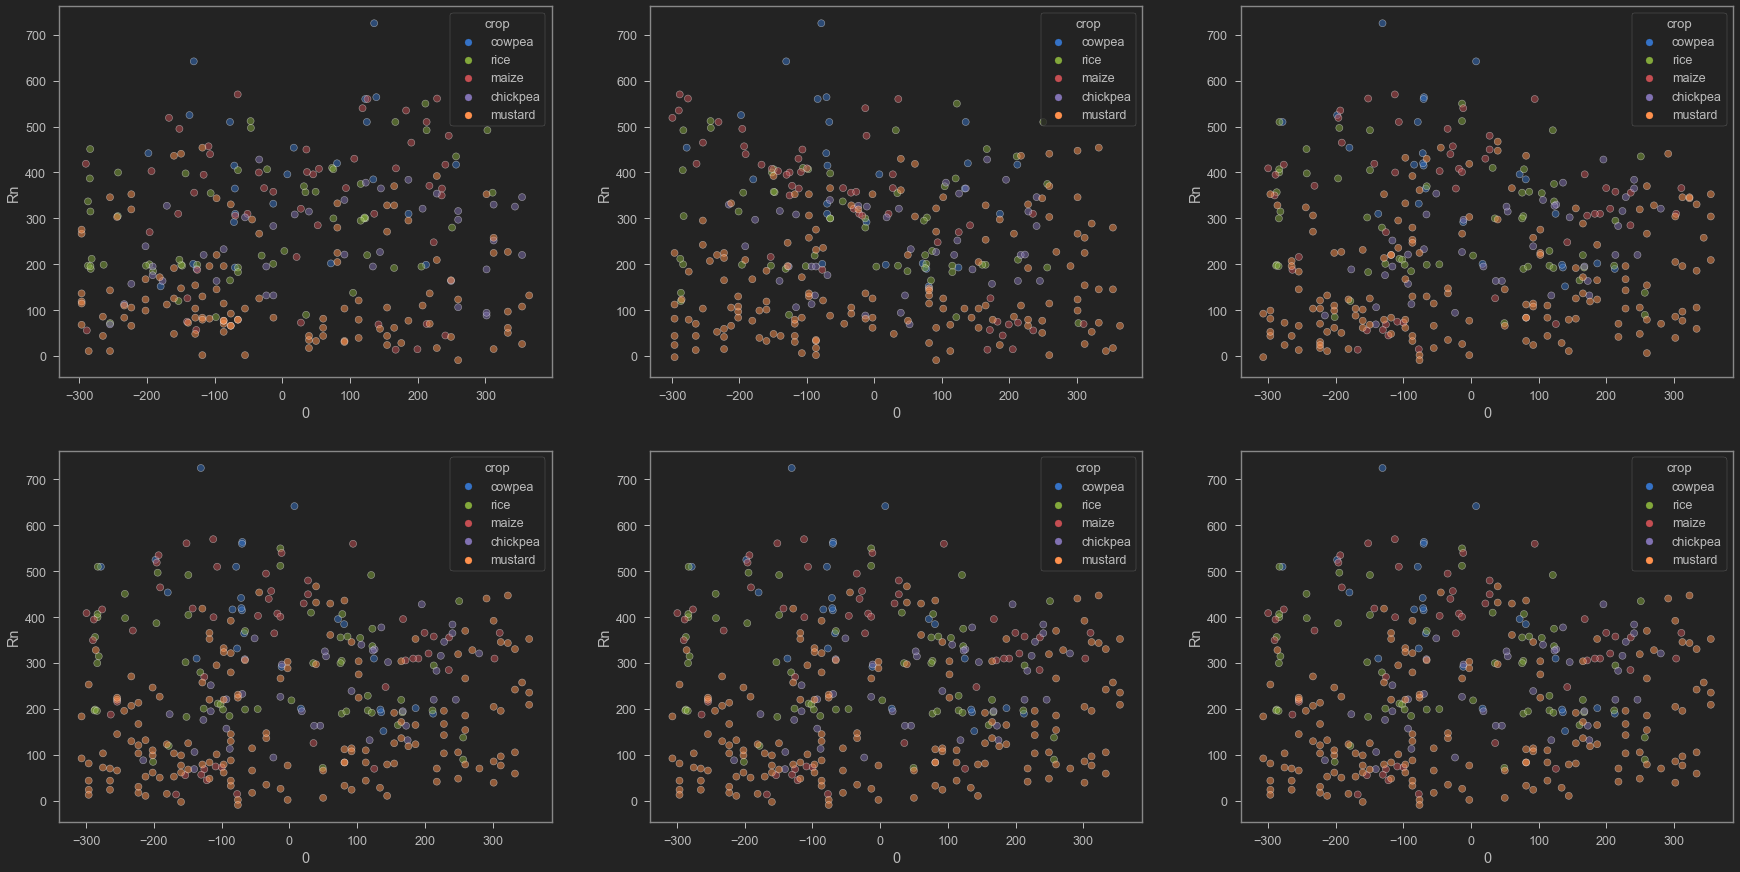

In [99]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30,15))
n_neighbors_list = [5,10,15,20,25,30]
for r in range(2):
    for c in range(3):
        pc = PCA(n_components=1)
        new_data = pc.fit_transform(data[feature_cols])
        clf = LocalOutlierFactor(n_neighbors=n_neighbors_list[r*3+c], p=2)
        non_outliers = []
        for i, outlier_label in enumerate(clf.fit_predict(new_data)):
            if outlier_label==1:
                non_outliers.append(new_data[i,:])
        new_data = pd.DataFrame(non_outliers)
        
        sns.scatterplot(x=new_data.iloc[:,0], y=data['Rn'], hue=data['crop'], alpha=0.5, ax=axes[r,c])

In [9]:
data.columns

Index(['crop_chickpea', 'crop_cowpea', 'crop_maize', 'crop_mustard',
       'crop_rice', 'Date', 'Time', 'GSR', 'CT', 'Rn', 'crop', 'ST_5cm',
       'ST_10cm', 'ST_15cm', 'timesin', 'timecos'],
      dtype='object')

<AxesSubplot:xlabel='GSR', ylabel='Rn'>

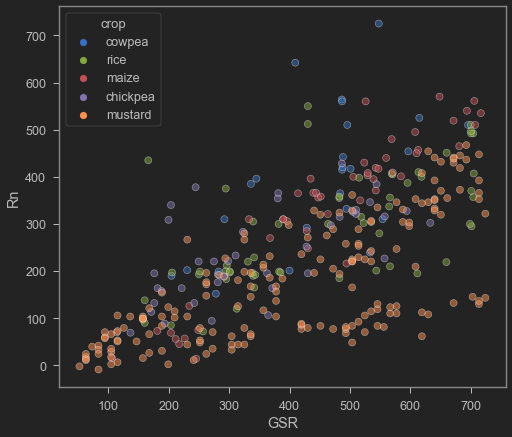

In [10]:
sns.scatterplot(x='GSR', y='Rn', data=data, hue='crop', alpha=0.5)

In [11]:
new_data = data[(data['GSR']<300) | (data['Rn']>150)]
new_data = new_data[(new_data['Rn']<500) | (new_data['crop']!='cowpea')]
new_data = new_data[(new_data['Rn']<400) | (new_data['GSR']>500) | (new_data['crop']!='rice')]
new_data = new_data[(new_data['Rn']<300) | (new_data['GSR']>375)]

<AxesSubplot:xlabel='GSR', ylabel='Rn'>

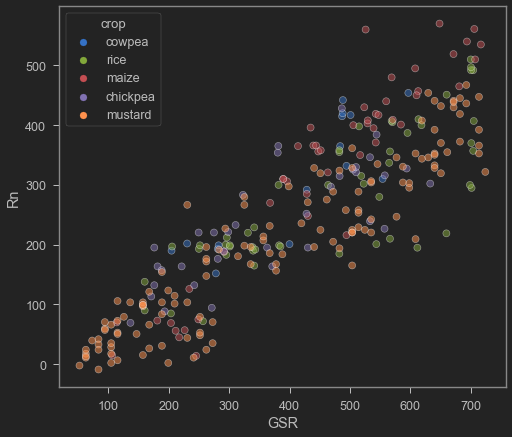

In [12]:
sns.scatterplot(x='GSR', y='Rn', data=new_data, hue='crop', alpha=0.5)

In [13]:
new_data['gsrxct'] = new_data['GSR']*new_data['CT']

<AxesSubplot:xlabel='gsrxct', ylabel='Rn'>

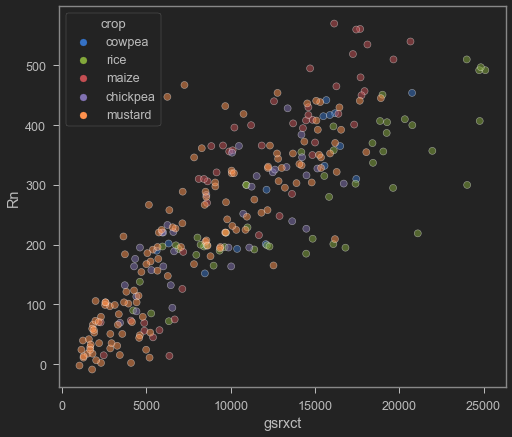

In [14]:
sns.scatterplot(x='gsrxct', y='Rn', data=new_data, hue='crop', alpha=0.5)

<AxesSubplot:xlabel='Rn', ylabel='Count'>

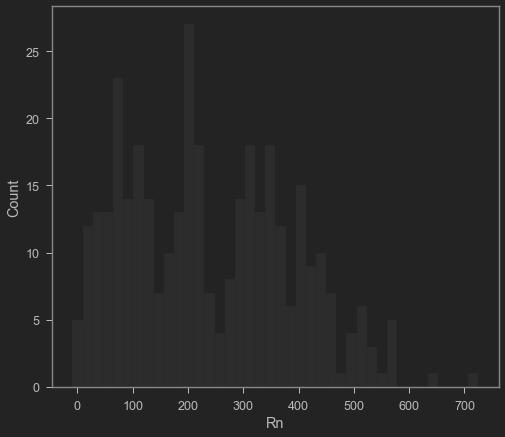

In [16]:
sns.histplot(data['Rn'], bins=40)

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

x1 = new_data[new_data['crop'].isin(['rice','cowpea','chickpea'])]
x2 = new_data[new_data['crop'].isin(['mustard','maize'])]

x1_train, x1_test, y1_train, y1_test = train_test_split(x1[feature_cols], x1['Rn'], test_size=0.1)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2[feature_cols], x2['Rn'], test_size=0.1)

rfr1 = RandomForestRegressor()
rfr2 = RandomForestRegressor()

feature_cols = [c for c in data.columns if c not in ['ST_5cm','ST_10cm','ST_15cm','Date','Time','crop','Rn']]
rfr1.fit(x1[feature_cols], x1['Rn'])
rfr2.fit(x2[feature_cols], x2['Rn'])

RandomForestRegressor()

In [26]:
from sklearn.metrics import mean_squared_error

print(np.mean(cross_val_score(rfr1, x1[feature_cols], x1['Rn'], cv=20, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(rfr2, x2[feature_cols], x2['Rn'], cv=20, scoring='neg_mean_squared_error')))

-4550.889461675266
-2870.3725150643813
